# Klasifikasi Berita bad, good, neutral menggunakan LSTM
Ryzki perdana emil 11031330039

### Import Data

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
#import data dari
df = pd.read_csv('E:/emil/code/data/dataset.csv')
print(len(df))
df.category.value_counts()

4055


neutral    1668
bad        1278
good       1109
Name: category, dtype: int64

In [ ]:
#mengambil sampel data
def sampel_data(data,n):
    if ndata==0:
      return data.sample(frac=1).reset_index(drop=True)
    n = round(n/3)
    data.sample(frac=1).reset_index(drop=True)
    data1 = df.loc[df['category'] == 'bad']                       # menampung data berlabel bad
    data2 = df.loc[df['category'] == 'good']                      # menampung data berlabel good
    data3 = df.loc[df['category'] == 'neutral']                   # menampung data berlabel neutral
    data1 = data1.sample(n)                                       # mengambil sampel data bad sebanyak n
    data2 = data2.sample(n)                                       # mengambil sampel data good sebanyak n
    data3 = data3.sample(n)                                       # mengambil sampel data neutral sebanyak n
    frames = [data1, data2, data3]                                # membuat dataframe baru berisi sample data 
    data = pd.concat(frames)                                      # menggabungkan sampel data bad,good dan neutral
    return data.sample(frac=1).reset_index(drop=True)             # mengacak seluruh data

501


In [ ]:
ndata = 500                                                       # masukan jumlah data yang akan dipakai (isi dengan '0' jika ingin menggunakan semua data)
data = sampel_data(df,ndata)
print(len(data))

### Preprocessing

In [ ]:
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
stemmer=PorterStemmer()

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # casefolding
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # menghapus punctuation
    text = BAD_SYMBOLS_RE.sub('', text) # menghapus punctuation
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # stopword removal
    text = ' '.join(stemmer.stem(word) for word in text.split()) # Stemming
    return text
data['text'] = data['text'].apply(clean_text)
data['text'] = data['text'].str.replace('\d+', '')
data.head()

,category,text
0,good,ad sale boost time warner profit quarterli pro...
1,good,itali get econom action plan italian prime min...
2,good,wmc profit amid bid critic australian mine fir...
3,neutral,commodor find new leas life oncefam commodor c...
4,neutral,bmw reveal new model pipelin bmw prepar enter ...


### Feature Engineering

In [ ]:
from collections import Counter

In [ ]:
# fungsi ini menerima input seluruh text dalam dataset dan memberi output jumlah kata unique
def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

counter = counter_word(data.text) # apply fungsi counter word
num_words = len(counter)
max_length = 400
num_words

10021

In [ ]:
from keras.preprocessing.text import Tokenizer

In [ ]:
MAX_NB_WORDS = 50000 # jumlah kata yang akan digunakan
MAX_SEQUENCE_LENGTH = 500 # jumlah kata dalam satu sekuen/satu row data
EMBEDDING_DIM = 50 # jumlah neuron dalam tiap layer

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True) # inisiasi tokenizer
tokenizer.fit_on_texts(data['text'].values) # inisiasi tokenizer
word_index = tokenizer.word_index # membuat indeks dari kata unique
print('Found %s unique tokens.' % len(word_index))

Found 10016 unique tokens.


In [ ]:
from keras.preprocessing.sequence import pad_sequences

In [ ]:
text = tokenizer.texts_to_sequences(data['text'].values) # data sequencing
text = pad_sequences(text, maxlen=MAX_SEQUENCE_LENGTH) # padding the sequences
label = pd.get_dummies(data['category']).values # variabel baru untuk menampung label dari data
print('Shape dari label tensor:', label.shape)
print('Shape dari data tensor:', text.shape)

Shape dari label tensor: (501, 3)
Shape dari data tensor: (501, 500)


### Model Training

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from sklearn.model_selection import KFold

In [ ]:
# inisiasi variabel input sequensial neural network
num_folds = 10
no_epochs = 40
batch_size = 64

# inisiasi variabel penampung akurasi dan loss untuk evaluasi
plot_acc_per_fold = pd.DataFrame()
plot_loss_per_fold = pd.DataFrame()
plot_val_acc_per_fold = pd.DataFrame()
plot_val_loss_per_fold = pd.DataFrame()
val_acc_per_fold = []
val_loss_per_fold = []

# inisiasi kfold
kfold = KFold(n_splits=num_folds, shuffle=True)
fold_no = 1

# apply kfold
for train, test in kfold.split(text, label):
    
    # Rancangan model
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.35))
    model.add(Dense(3, activation='softmax'))
    
    # Apply model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    # Hasil evaluasi
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    # Fit data to model
    history = model.fit(text[train], label[train],
                        validation_data = (text[test], label[test]),
                        batch_size=batch_size,
                        epochs=no_epochs)
    
    # menyimpan history tiap fold
    plot_acc_per_fold[str(fold_no)] = history.history['accuracy']
    plot_val_acc_per_fold[str(fold_no)] = history.history['val_accuracy']
    plot_loss_per_fold[str(fold_no)] = history.history['loss']
    plot_val_loss_per_fold[str(fold_no)] = history.history['val_loss']
    
    # pembuatan metriks evaluasi
    scores = model.evaluate(text[test], label[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    val_acc_per_fold.append(scores[1] * 100)
    val_loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1

# == meanmpilkan akurasi tiap fold dan rata-rata seluruhnya ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(val_acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {val_loss_per_fold[i]} - Accuracy: {val_acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(val_acc_per_fold)} (+- {np.std(val_acc_per_fold)})')
print(f'> Loss: {np.mean(val_loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Train on 450 samples, validate on 51 samples
Epoch 1/40
450/450 [==============================] - 6s 13ms/step - loss: 1.0992 - accuracy: 0.3200 - val_loss: 1.0995 - val_accuracy: 0.3333
Epoch 2/40
450/450 [==============================] - 4s 10ms/step - loss: 1.0938 - accuracy: 0.4644 - val_loss: 1.0980 - val_accuracy: 0.3529
Epoch 3/40
450/450 [==============================] - 5s 10ms/step - loss: 1.0852 - accuracy: 0.5689 - val_loss: 1.0979 - val_accuracy: 0.3725
Epoch 4/40
450/450 [==============================] - 5s 10ms/step - loss: 1.0669 - accuracy: 0.6111 - val_loss: 1.0954 - val_accuracy: 0.3529
Epoch 5/40
450/450 [==============================] - 5s 10ms/step - loss: 1.0146 - accuracy: 0.7711 - val_loss: 1.6181 - val_accuracy: 0.3333
Epoch 6/40
450/450 [==============================] - 5s 10ms/step - loss: 1.0052 - accuracy: 0.7400 - val_loss: 1.0582 - val_accuracy: 0.4510


451/451 [==============================] - 5s 11ms/step - loss: 0.0152 - accuracy: 0.9956 - val_loss: 1.7050 - val_accuracy: 0.6800
Epoch 31/40
451/451 [==============================] - 5s 11ms/step - loss: 0.0198 - accuracy: 0.9978 - val_loss: 1.6396 - val_accuracy: 0.7000
Epoch 32/40
451/451 [==============================] - 5s 11ms/step - loss: 0.0219 - accuracy: 0.9933 - val_loss: 1.5505 - val_accuracy: 0.6600
Epoch 33/40
451/451 [==============================] - 5s 12ms/step - loss: 0.0161 - accuracy: 0.9956 - val_loss: 1.6310 - val_accuracy: 0.6800
Epoch 34/40
451/451 [==============================] - 5s 11ms/step - loss: 0.0138 - accuracy: 0.9956 - val_loss: 1.7385 - val_accuracy: 0.6600
Epoch 35/40
451/451 [==============================] - 5s 11ms/step - loss: 0.0138 - accuracy: 0.9956 - val_loss: 1.7210 - val_accuracy: 0.6800
Epoch 36/40
451/451 [==============================] - 5s 11ms/step - loss: 0.0122 - accuracy: 0.9956 - val_loss: 1.6364 - val_accuracy: 0.7000
Epoc

451/451 [==============================] - 5s 10ms/step - loss: 1.0591 - accuracy: 0.4235 - val_loss: 1.0692 - val_accuracy: 0.4400
Epoch 5/40
451/451 [==============================] - 4s 10ms/step - loss: 0.9793 - accuracy: 0.7228 - val_loss: 1.0620 - val_accuracy: 0.5400
Epoch 6/40
451/451 [==============================] - 5s 11ms/step - loss: 0.9145 - accuracy: 0.9047 - val_loss: 1.0267 - val_accuracy: 0.5200
Epoch 7/40
451/451 [==============================] - 4s 10ms/step - loss: 0.7924 - accuracy: 0.7650 - val_loss: 1.0069 - val_accuracy: 0.5000
Epoch 8/40
451/451 [==============================] - 5s 10ms/step - loss: 0.6451 - accuracy: 0.9180 - val_loss: 0.9885 - val_accuracy: 0.5400
Epoch 9/40
451/451 [==============================] - 5s 11ms/step - loss: 0.5183 - accuracy: 0.8869 - val_loss: 0.9801 - val_accuracy: 0.5600
Epoch 10/40
451/451 [==============================] - 5s 11ms/step - loss: 0.3592 - accuracy: 0.9845 - val_loss: 0.9826 - val_accuracy: 0.4600
Epoch 11/

451/451 [==============================] - 5s 10ms/step - loss: 0.0126 - accuracy: 0.9978 - val_loss: 2.3900 - val_accuracy: 0.4000
Epoch 35/40
451/451 [==============================] - 5s 10ms/step - loss: 0.0107 - accuracy: 0.9978 - val_loss: 2.3943 - val_accuracy: 0.4000
Epoch 36/40
451/451 [==============================] - 5s 10ms/step - loss: 0.0092 - accuracy: 0.9978 - val_loss: 2.4143 - val_accuracy: 0.4000
Epoch 37/40
451/451 [==============================] - 5s 10ms/step - loss: 0.0107 - accuracy: 0.9978 - val_loss: 2.4377 - val_accuracy: 0.4200
Epoch 38/40
451/451 [==============================] - 5s 10ms/step - loss: 0.0080 - accuracy: 0.9978 - val_loss: 2.4663 - val_accuracy: 0.4200
Epoch 39/40
451/451 [==============================] - 5s 10ms/step - loss: 0.0074 - accuracy: 0.9978 - val_loss: 2.4932 - val_accuracy: 0.4200
Epoch 40/40
451/451 [==============================] - 5s 10ms/step - loss: 0.0082 - accuracy: 0.9956 - val_loss: 2.5393 - val_accuracy: 0.4200
Scor

451/451 [==============================] - 5s 11ms/step - loss: 0.5826 - accuracy: 0.7162 - val_loss: 1.1390 - val_accuracy: 0.5800
Epoch 9/40
451/451 [==============================] - 5s 11ms/step - loss: 0.4877 - accuracy: 0.7827 - val_loss: 1.1562 - val_accuracy: 0.6400
Epoch 10/40
451/451 [==============================] - 5s 12ms/step - loss: 0.3800 - accuracy: 0.8714 - val_loss: 1.1526 - val_accuracy: 0.4600
Epoch 11/40
451/451 [==============================] - 5s 12ms/step - loss: 0.2603 - accuracy: 0.9468 - val_loss: 1.1120 - val_accuracy: 0.6400
Epoch 12/40
451/451 [==============================] - 5s 12ms/step - loss: 0.2112 - accuracy: 0.9357 - val_loss: 1.0149 - val_accuracy: 0.6400
Epoch 13/40
451/451 [==============================] - 5s 10ms/step - loss: 0.1503 - accuracy: 0.9889 - val_loss: 1.1145 - val_accuracy: 0.5800
Epoch 14/40
451/451 [==============================] - 5s 11ms/step - loss: 0.0707 - accuracy: 0.9911 - val_loss: 1.3522 - val_accuracy: 0.6400
Epoch

### Grafik

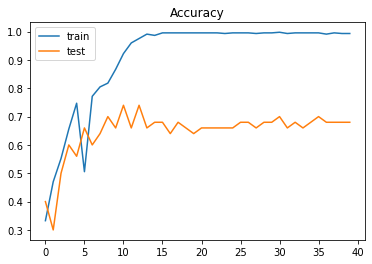

In [ ]:
import matplotlib.pyplot as plt

plot = '3'

plt.title('Accuracy')
plt.plot(plot_acc_per_fold[plot], label='train')
plt.plot(plot_val_acc_per_fold[plot], label='test')
plt.legend()
plt.show();